This notebook can be used to read whole slide images directly from the s3 bucket with the WholeSlideData package

I will add more functionality to this notebook, including training a model

A word of caution:

reading images from s3 to train a model might take a long time - I will test the training time 

In [1]:
!python --version

Python 3.7.13


In [2]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:57
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!pip install opencv-python

In [ ]:
!pip install tiffslide

In [ ]:
!pip install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main

In [ ]:
!pip install s3fs

In [ ]:
!pip install boto3

In [7]:
from wholeslidedata.image.wholeslideimage import WholeSlideImage

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/wholeslidedata/accessories/tiffslide/backend.py:6: UserWarning: compatibility: aliasing tiffslide.TiffSlide to 'OpenSlide'
  from tiffslide import OpenSlide


In [8]:
s3_wsi_url = 's3://tiger-training/wsirois/wsi-level-annotations/images/114S.tif'

In [9]:
# open a WSI
with WholeSlideImage(s3_wsi_url, backend='tiffslide') as wsi:
    print('\n\nWSI properties\n---------------\n')
    # print some properties
    print(f'available spacing in {wsi.path}:\n{wsi.spacings}\n')
    print(f'shapes in {wsi.path}:\n{wsi.shapes}\n')
    print(f'downsampling ratios in {wsi.path}:\n{wsi.downsamplings}\n')
    print(f'closest real spacing from rounded spacing: 0.5 = {wsi.get_real_spacing(0.5)}\n')
    print(f'size given spacing: shape at spacing 0.5 = {wsi.shapes[wsi.get_level_from_spacing(0.5)]}\n')



WSI properties
---------------

available spacing in s3://tiger-training/wsirois/wsi-level-annotations/images/114S.tif:
[0.45669399219053275, 0.9133879843810655, 1.826775968762131, 3.653551937524262, 7.307103875048524, 14.614207750097048, 29.228415500194096, 58.48726934194594]

shapes in s3://tiger-training/wsirois/wsi-level-annotations/images/114S.tif:
((61504, 43392), (30752, 21696), (15376, 10848), (7688, 5424), (3844, 2712), (1922, 1356), (961, 678), (480, 339))

downsampling ratios in s3://tiger-training/wsirois/wsi-level-annotations/images/114S.tif:
(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.06664931459193)

closest real spacing from rounded spacing: 0.5 = 0.45669399219053275

size given spacing: shape at spacing 0.5 = (61504, 43392)





Patch and Slide extraction
---------------



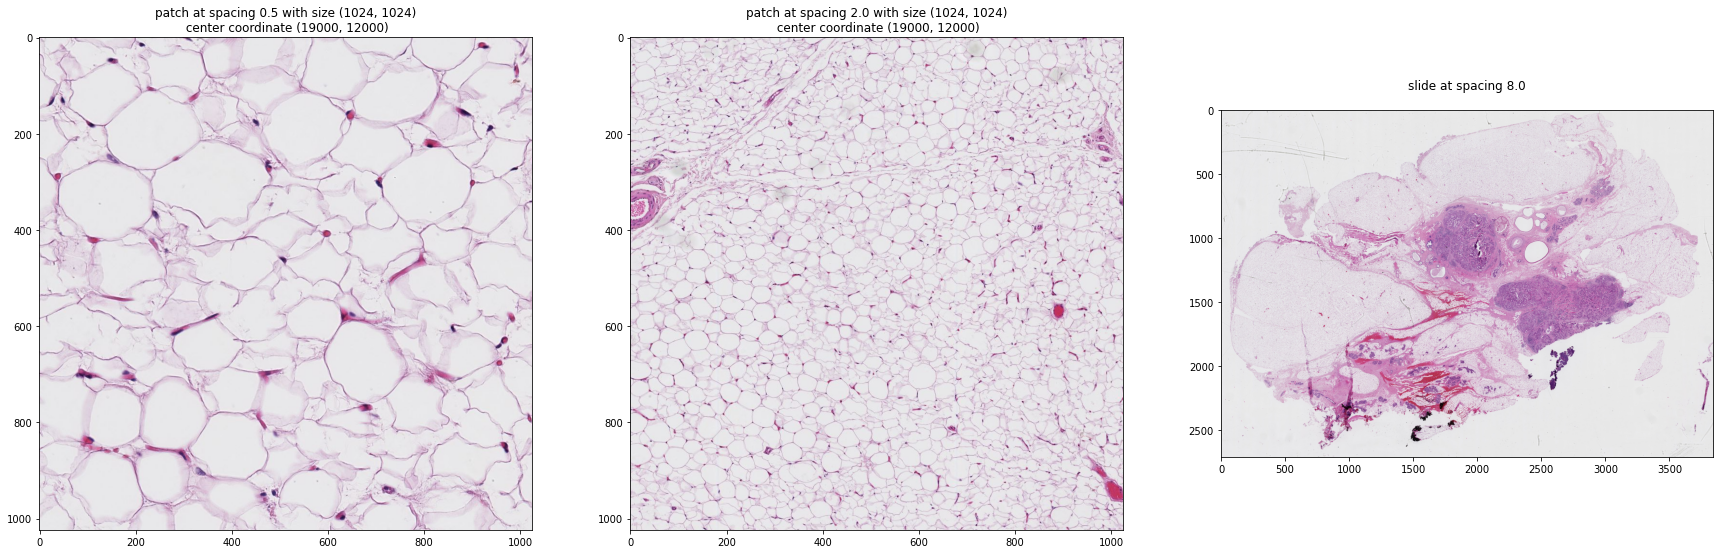

In [10]:
x,y = 19000, 12000
width, height = 1024, 1024


print('\n\nPatch and Slide extraction\n---------------\n')
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

with WholeSlideImage(s3_wsi_url, backend='tiffslide') as wsi:
    # extract a patch with center coordinates xy at spacing 0.5
    spacing = 0.5
    patch = wsi.get_patch(x, y, width, height, spacing)

    # plot patch
    axes[0].imshow(patch)
    axes[0].set_title(f'patch at spacing {spacing} with size {width, height}\n center coordinate {x,y}')

    spacing = 2.0
    # extract a patch with center coordinates xy at spacing 2.0
    patch = wsi.get_patch(x, y, width, height, spacing)

    # plot patch
    axes[1].imshow(patch)
    axes[1].set_title(f'patch at spacing {spacing} with size {width, height}\n center coordinate {x,y}')

    # extract the whole slide
    slide_spacing=8.0
    slide = wsi.get_slide(spacing=slide_spacing)

    axes[2].imshow(slide)
    axes[2].set_title(f'slide at spacing {slide_spacing}\n')
    plt.show()

read annotations from s3

In [11]:
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.annotation.utils import plot_annotations
from matplotlib import pyplot as plt
from pprint import pprint
from wholeslidedata.annotation import utils as annotation_utils


In [12]:
s3_xml_url = 's3://tiger-training/wsirois/wsi-level-annotations/annotations-tissue-bcss-xmls/TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297.xml'

In [13]:
wsa = WholeSlideAnnotation(s3_xml_url, parser='s3asap')

print(f'\nlabel_map: {wsa.labels.map}')
print(f'\ncounts per label:  {annotation_utils.get_counts_in_annotations(wsa.annotations, wsa.labels)}')
print(f'\npixels per label:  {annotation_utils.get_pixels_in_annotations(wsa.annotations, wsa.labels)}')


label_map: {'invasive tumor': 3, 'tumor-associated stroma': 2, 'necrosis not in-situ': 5, 'inflamed stroma': 1, 'rest': 6, 'roi': 4}

counts per label:  {'invasive tumor': 64, 'tumor-associated stroma': 38, 'necrosis not in-situ': 1, 'inflamed stroma': 17, 'rest': 7, 'roi': 1}

pixels per label:  {'invasive tumor': 1382676, 'tumor-associated stroma': 1266681, 'necrosis not in-situ': 891504, 'inflamed stroma': 1531, 'rest': 14282, 'roi': 2947945}


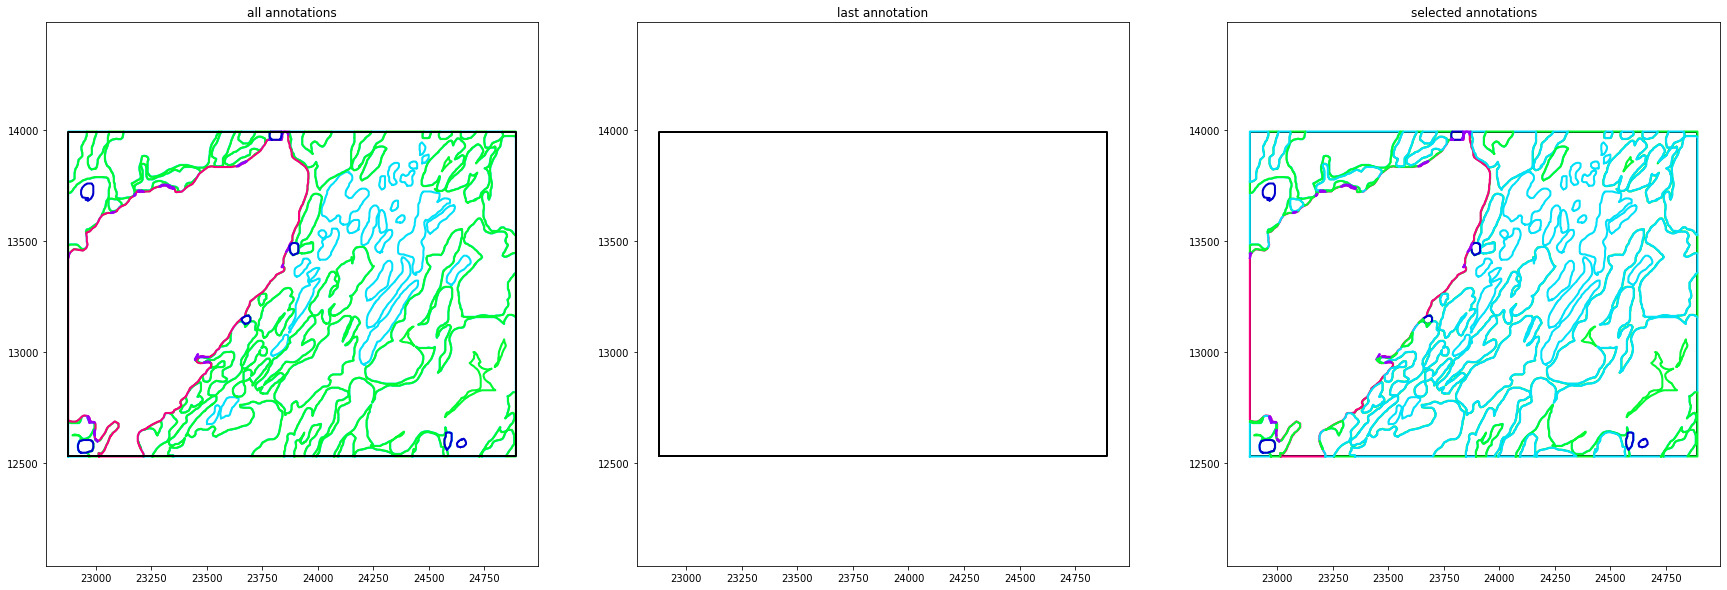

In [14]:
"""
After creating a whole slide annotation, we can plot all the annotation within it
"""

fig, axes = plt.subplots(1,3, figsize=(30,10))
annotations = wsa.annotations
plot_annotations(annotations, axes[0], title='all annotations')


"""
We can also plot a specific annotattion for example the last annotation
"""

annotations = wsa.annotations
annotation = annotations[-1]
plot_annotations([annotation], axes[1], title='last annotation')


"""
Furthemore we can select all annotations in a specific region based on a center coordinate, a width and a heigth. 
"""

center = wsa.annotations[-1].center
width, height = 10000, 10000

selected_annotations = wsa.select_annotations(*center, width, height)

plot_annotations(selected_annotations, axes[2], title='selected annotations')
plt.show()